# Path Optimisation Solution

## Problem Summary

<p>A company called Protea Treks' wants to optimise the path of a new trail that they are planning to build in a montainous region of the Free State. The trail is intended to be a begginer's trail that must not require too much exertion on behalf of its participants.</p>

> The solution will be divded by the following sections:
>
> - **Ingestion:** Read and extract data from the provided .csv files *(altitude map and energy expenditure measurments)*.
> - **Modelling:** Build a model to predict a person's expected energy expenditure for a given gradient based on the energy cost data.
> - **Optimisation:** Find the optimal path from any point on the Southern border of the map to the lodge entrance that minimizes the total expected exertion.
> - **Reporting:** Write the optimal path to a .csv file and create a visualization of the path overlaid on the altitude map in a .png file.
> - **Future improvements:** Provide suggestions on additional information required and potential changes in approach for a future endurance trail.

### Libraries

Lets declare the libraries to use in this solution beforehand.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import heapq

## Ingestion

The available data for this problem is the following:
- **energy_cost.csv**
   - This table contains the measurements from a sports science lab that relates the walking gradient/slope on a treadmill with the energy expended of multiple test subjects. 
     > *Energy expenditure is measured in $J.kg^{-1}.min^{-1}$, calculated based on oxygen consumption and treadmill speed*
- **altitude_map.csv**
   - This table contains information that describes an altitud map of the region of interest.
     > *The altitude map is at resolution of 10m x 10m, measurements are in meters, with North and the Y-axis going up vertically*


### Data

#### Energy Cost

In [2]:
# Reading CSV file into a DataFrame
en_cost_df = pd.read_csv('energy_cost.csv')

# Display the first few rows of the Energy Cost DataFrame to check the data
print(en_cost_df.head())

   gradient  energy_cost
0  0.452115    14.831670
1 -0.002166     0.654312
2  0.457171    16.240977
3 -0.300818     2.331962
4 -0.200292     0.801025


In [3]:
# Summary Stats
summary_stats = en_cost_df.describe()
print('Summary Stats:')
print(summary_stats)

Summary Stats:
        gradient  energy_cost
count  65.000000    65.000000
mean   -0.000129     6.307908
std     0.312557     5.446556
min    -0.459229     0.455766
25%    -0.302084     2.067310
50%    -0.002166     3.497927
75%     0.302220    11.649117
max     0.458577    17.383337


In [4]:
# Correlation Analysis
correlation_matrix = en_cost_df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
             gradient  energy_cost
gradient     1.000000     0.852432
energy_cost  0.852432     1.000000


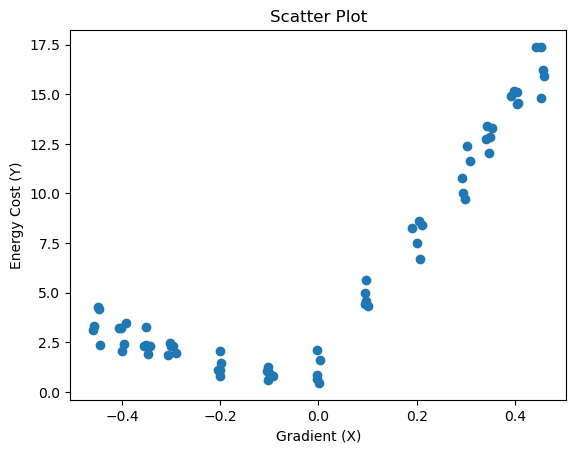

In [5]:
# Scatter Plot
plt.scatter(en_cost_df['gradient'], en_cost_df['energy_cost'])
plt.xlabel('Gradient (X)')
plt.ylabel('Energy Cost (Y)')
plt.title('Scatter Plot')
plt.show()

#### Altitude Map

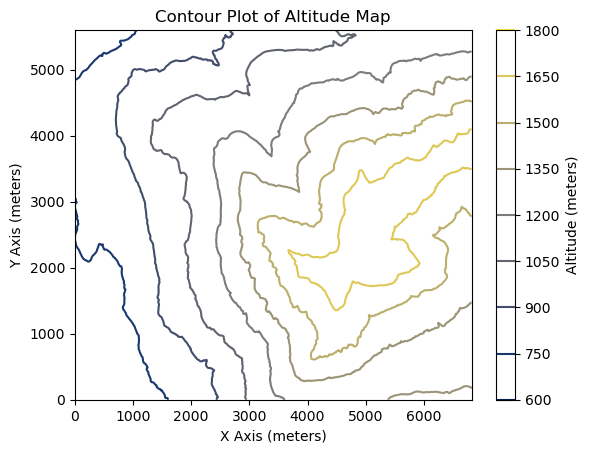

In [6]:
# Reading CSV file into a DataFrame
al_map_df = pd.read_csv('altitude_map.csv', header=None)

# DataFrame into a 2D NumPy array
altitude_map_arr = al_map_df.values

# Dimensions of the map
rows, cols = altitude_map_arr.shape
x_range = range(0, cols * 10, 10)  # Each cell represents 10m, so the range goes from 0 to (cols * 10) meters
y_range = range(0, rows * 10, 10)  # Same for the Y-axis

# Plotting the map (BEST TO ADD A SUBTITLE WITH THE RESOLUTION 10M X 10M)
plt.contour(x_range, y_range, altitude_map_arr, levels=10, cmap='cividis')
plt.colorbar(label='Altitude (meters)')
plt.title('Contour Plot of Altitude Map')
plt.xlabel('X Axis (meters)')
plt.ylabel('Y Axis (meters)')
plt.show()

## Modelling

For the modelling part, the objective is to apply a statistics/ML method to predict a person's expected energy expenditure for a given gradient.
<br><br>
Since the dataset in question is rather small with only one independent variable and one dependent variable, then a simple and effective method for prediction would be a Linear Regression. But, as we can observe in the scatter plot of the DataFrame, there is an _exponential_ relationship between the variables.
<br><br>
Therefore, a simple linear regression may not fully capture the non-linear behavior effectively, so instead lets use a **Polynomial Regression**, which can capture higher-order relationships.

In [7]:
# Split data
X = en_cost_df[['gradient']]
y = en_cost_df['energy_cost']

In [8]:
# Testing different polynomial degrees and selecting the best-fit model based on R-squared score
degrees = range(1, 4)
best_r2 = -np.inf
best_degree = None
best_model = None

for degree in degrees:
    # Apply PolynomialFeatures to transform X to higher-degree features
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)

    # Create and fit the Polynomial Regression model
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)

    # Make predictions using the model
    y_pred = poly_model.predict(X_poly)

    # Calculate the R-squared score
    r2 = r2_score(y, y_pred)

    # Keeping the model with higher R-squared score
    if r2 > best_r2:
        best_r2 = r2
        best_degree = degree
        best_model = poly_model

In [9]:
# Best-fit model predictions
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_poly_pred = PolynomialFeatures(degree=best_degree).fit_transform(X_pred)
y_pred = best_model.predict(X_poly_pred)

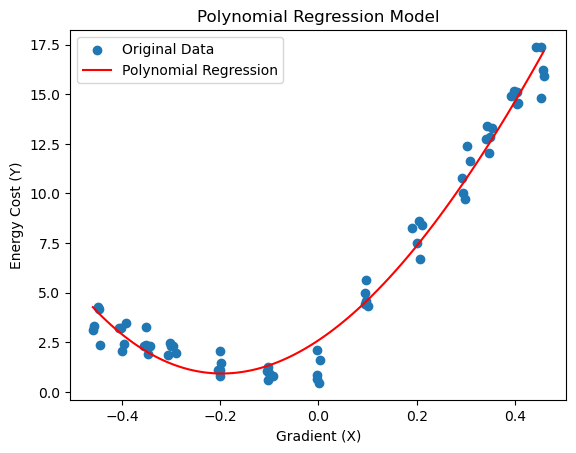

Best-fit Model:
Degree: 3
R-squared Score (R2): 0.9754290728037109


In [10]:
# Plotting original data vs the best-fit poly model
plt.scatter(X, y, label='Original Data')
plt.plot(X_pred, y_pred, color='red', label='Polynomial Regression')
plt.xlabel('Gradient (X)')
plt.ylabel('Energy Cost (Y)')
plt.title('Polynomial Regression Model')
plt.legend()
plt.show()

# Print the best-fit model's degree and R-squared score
print("Best-fit Model:")
print("Degree:", best_degree)
print("R-squared Score (R2):", best_r2)


## Optimisation

Now, for the Optimisation part of the solution, it is indicated to find a path from any point on the southern border of the map to a lodge entrance at $x=200$ and $y=559$, which minimises the total expected exertion (in Joules) using any optimisation method that runs within a reasonable amount of time.
> For simplicity: Lets asume that trail participants have a fixed body mass and a fixed walking speed.

Since the A* algorithm typically performs well in pathfinding problems like this one, we'll use it for our optimisation.

In [11]:
# Lets adjust the gradient values for each point in the map.
def calculate_gradient(altitude_map, point):
    x, y = point
    if x == 0 or x == altitude_map.shape[0] - 1 or y == 0 or y == altitude_map.shape[1] - 1:
        return 0.0  # Border points have a gradient of 0
    else:
        dx = altitude_map[x + 1, y] - altitude_map[x - 1, y]
        dy = altitude_map[x, y + 1] - altitude_map[x, y - 1]
        return np.arctan2(dy, dx)

In [12]:
# Since we are looking to minimize the energy expenditure, lets use the straight-line distance as the heuristic
def heuristic_cost_estimate(point, goal):
    # Calculate the straight-line distance from 'point' to the 'goal'
    return np.sqrt((goal[0] - point[0]) ** 2 + (goal[1] - point[1]) ** 2)

In [13]:
# Determining its neighboring points
def get_neighbors(point, altitude_map):
    # Get adjacent points from the altitude map
    neighbors = []
    x, y = point

    if x > 0:
        neighbors.append((x - 1, y))
    if x < altitude_map.shape[0] - 1:
        neighbors.append((x + 1, y))
    if y > 0:
        neighbors.append((x, y - 1))
    if y <  altitude_map.shape[1] - 1:
        neighbors.append((x, y + 1))

    return neighbors    

In [14]:
# Implementing the A* search algorithm
def a_star_search(altitude_map, start, goal, model):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic_cost_estimate(start, goal)}

    # Keep track of points in the open set using a hash table
    open_set_hash = {start}

    while open_set:
        _, current = heapq.heappop(open_set)
        open_set_hash.remove(current)

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        for neighbor in get_neighbors(current, altitude_map):
            neighbor_gradient = calculate_gradient(altitude_map, neighbor)
            neighbor_altitude = altitude_map[neighbor]

            # Generate polynomial features for the neighbor
            polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
            neighbor_features = np.array([neighbor_altitude]).reshape(1, 1) # Reshape to 2D array
            neighbor_features_poly = polynomial_features.fit_transform(neighbor_features)

            # Concatenate gradient and polynomial features
            neighbor_features_poly = np.concatenate([neighbor_features_poly, [[neighbor_gradient]]], axis=1)

            # Calculate the tentative g_score for the neighbor
            tentative_g_score = g_score[current] + model.predict(neighbor_features_poly)[0]

            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic_cost_estimate(neighbor, goal)
                if neighbor not in open_set_hash:
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
                    open_set_hash.add(neighbor)

    return None  # No path found

In [15]:
# Now, lets find the optimal path from any point in the south border to the given goal, which is (200, 559)
start = (558, 0)
goal = (200, 559)
optimal_path = a_star_search(al_map_df.values, start, goal, best_model)
print(optimal_path)

[(558, 0), (557, 0), (556, 0), (555, 0), (554, 0), (553, 0), (552, 0), (551, 0), (550, 0), (549, 0), (548, 0), (547, 0), (546, 0), (545, 0), (544, 0), (543, 0), (542, 0), (541, 0), (540, 0), (539, 0), (538, 0), (537, 0), (536, 0), (535, 0), (534, 0), (533, 0), (532, 0), (531, 0), (530, 0), (529, 0), (528, 0), (527, 0), (526, 0), (525, 0), (524, 0), (523, 0), (522, 0), (521, 0), (520, 0), (519, 0), (518, 0), (517, 0), (516, 0), (515, 0), (514, 0), (513, 0), (512, 0), (511, 0), (510, 0), (509, 0), (508, 0), (507, 0), (506, 0), (505, 0), (504, 0), (503, 0), (502, 0), (501, 0), (500, 0), (499, 0), (498, 0), (497, 0), (496, 0), (495, 0), (494, 0), (493, 0), (492, 0), (491, 0), (490, 0), (489, 0), (488, 0), (487, 0), (486, 0), (485, 0), (484, 0), (483, 0), (482, 0), (481, 0), (480, 0), (479, 0), (478, 0), (477, 0), (476, 0), (475, 0), (474, 0), (473, 0), (472, 0), (471, 0), (470, 0), (469, 0), (468, 0), (467, 0), (466, 0), (465, 0), (464, 0), (463, 0), (462, 0), (461, 0), (460, 0), (459, 0),

## Reporting

Now that the optimal path has been found, lets create a visualization of the path overlaid on the altitude map in a .png file.

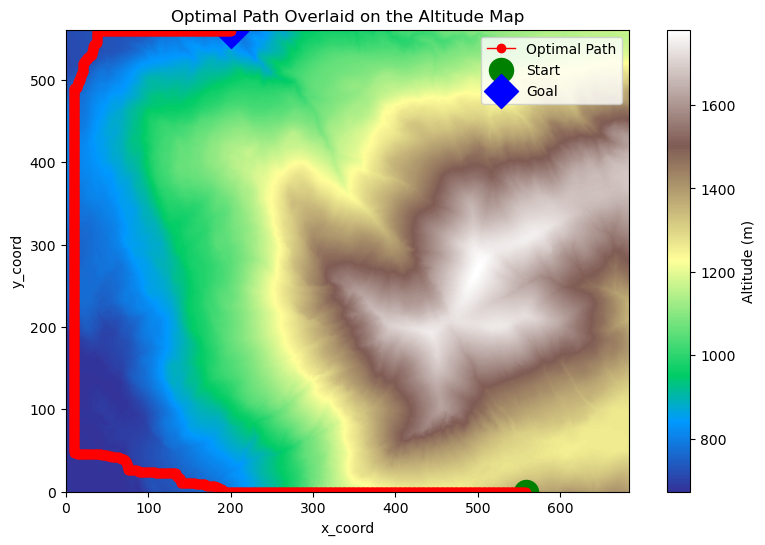

In [24]:
def write_path_solution(optimal_path, output_csv):
    # Convert the optimal_path to a DataFrame with columns "x_coord" and "y_coord"
    path_df = pd.DataFrame(optimal_path, columns=["x_coord", "y_coord"])
    # Save the DataFrame to a .csv file
    path_df.to_csv(output_csv, index=False)

def solution_map(altitude_map, optimal_path, output_png):
    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the altitude map
    im = ax.imshow(altitude_map, cmap="terrain", origin="lower", extent=[0, altitude_map.shape[1], 0, altitude_map.shape[0]])
    plt.colorbar(im, ax=ax, label="Altitude (m)")
    
    # Extract x and y coordinates from the optimal path
    x_coords = [point[0] for point in optimal_path]
    y_coords = [point[1] for point in optimal_path]
    
    # Plot the optimal path over the altitude map
    ax.plot(x_coords, y_coords, color="red", linewidth=1, marker="o", label="Optimal Path")
    
    # Plot the start point with a circle marker
    ax.scatter(start[0], start[1], color="green", marker="o", s=300, label="Start")
    
    # Plot the goal point with a diamond marker
    ax.scatter(goal[0], goal[1], color="blue", marker="D", s=300, label="Goal")
    
    
    # Set axis labels and title
    ax.set_xlabel("x_coord")
    ax.set_ylabel("y_coord")
    ax.set_title("Optimal Path Overlaid on the Altitude Map")
    ax.legend()
    
    # Save the visualization as a .png file
    plt.savefig(output_png)
    plt.show()

# Save objects into the desired files
output_csv = "optimal_path_coords.csv"
output_png = "optimal_path_visualization.png"

write_path_solution(optimal_path, output_csv)
solution_map(al_map_df.values, optimal_path, output_png)


## Future improvements

As a final step and as a manner of conclussion, lets write into a .txt file a brief explanation of what other information i would like to request from the company and how it might change my approach in the future to improve the solution and enhance the user experience.

In [26]:
def write_advice_to_txt(advice, output_txt):
    with open(output_txt, 'w') as file:
        file.write(advice)

advice_sentence = "To optimize the trail construction for Protea Treks, consider gathering participant-specific data like body mass, walking speed, and any medical conditions. Incorporate real-time weather conditions, terrain information such as surface roughness or obstacles, and employ advanced machine learning techniques for accurate energy expenditure predictions. Utilize user feedback and trail usage data for dynamic adjustments, tailoring the path to user preferences or skill level, and improving the overall trekking experience. This data-driven approach ensures an energy-efficient beginner's trail that offers an enhanced adventure."

output_txt = "optimal_path_advice.txt"

write_advice_to_txt(advice_sentence, output_txt)